In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import functools

In [2]:
# leer las trayectorias generadas
import h5py

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    trayectorias = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
trayectorias = tf.constant(trayectorias, dtype=tf.float32)
trayectorias

<tf.Tensor: shape=(300, 2, 300), dtype=float32, numpy=
array([[[-1.2586555 , -0.9773873 , -0.6782683 , ...,  1.624628  ,
          1.7963672 ,  1.9149516 ],
        [ 2.0501766 ,  2.1636293 ,  2.3194766 , ...,  1.4783727 ,
          1.0851953 ,  0.69141203]],

       [[ 3.0631616 ,  2.835756  ,  2.653766  , ...,  1.1529621 ,
          0.97086245,  0.7706821 ],
        [-1.9707173 , -1.4881412 , -1.2625027 , ..., -1.2967448 ,
         -1.4271919 , -1.5677058 ]],

       [[-2.8087697 , -3.1943452 , -3.3633764 , ..., -1.7944589 ,
         -1.9141258 , -1.9831786 ],
        [-3.9048054 , -1.9550904 , -0.68802756, ..., -1.0937202 ,
         -0.69908524, -0.34127188]],

       ...,

       [[ 1.9798769 ,  2.4639878 ,  2.7748594 , ...,  2.0065894 ,
          1.9940515 ,  1.9514239 ],
        [ 4.2296705 ,  2.9731817 ,  1.7047089 , ...,  0.0324259 ,
         -0.2146884 , -0.4149652 ]],

       [[ 3.8130639 ,  3.3691685 ,  3.1061964 , ...,  1.6743972 ,
          1.5496833 ,  1.4094348 ],
      

In [3]:
# n_particula, (posicion,velocidad), tiempo
trayectorias.shape
#TensorShape([300,2,300])

TensorShape([300, 2, 300])

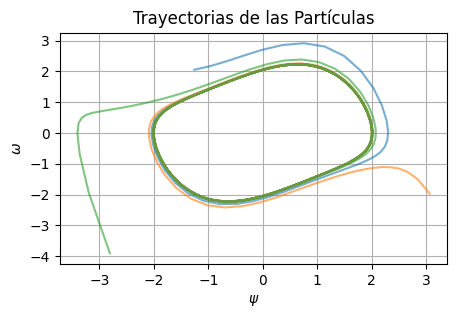

In [4]:
def plot_trayectoria(trayectorias, N):
    plt.figure(figsize=(5, 3))
    if len(trayectorias.shape) == 2:
        print('one data point')
        plt.plot(trayectorias[0], trayectorias[1], alpha=0.6)

    else:
        for i in range(N):
            plt.plot(trayectorias[i][0], trayectorias[i][1], alpha=0.6)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\omega$')
    plt.title('Trayectorias de las Partículas')
    plt.grid()
    plt.show()

plot_trayectoria(trayectorias, 3)

In [5]:
trayectorias

<tf.Tensor: shape=(300, 2, 300), dtype=float32, numpy=
array([[[-1.2586555 , -0.9773873 , -0.6782683 , ...,  1.624628  ,
          1.7963672 ,  1.9149516 ],
        [ 2.0501766 ,  2.1636293 ,  2.3194766 , ...,  1.4783727 ,
          1.0851953 ,  0.69141203]],

       [[ 3.0631616 ,  2.835756  ,  2.653766  , ...,  1.1529621 ,
          0.97086245,  0.7706821 ],
        [-1.9707173 , -1.4881412 , -1.2625027 , ..., -1.2967448 ,
         -1.4271919 , -1.5677058 ]],

       [[-2.8087697 , -3.1943452 , -3.3633764 , ..., -1.7944589 ,
         -1.9141258 , -1.9831786 ],
        [-3.9048054 , -1.9550904 , -0.68802756, ..., -1.0937202 ,
         -0.69908524, -0.34127188]],

       ...,

       [[ 1.9798769 ,  2.4639878 ,  2.7748594 , ...,  2.0065894 ,
          1.9940515 ,  1.9514239 ],
        [ 4.2296705 ,  2.9731817 ,  1.7047089 , ...,  0.0324259 ,
         -0.2146884 , -0.4149652 ]],

       [[ 3.8130639 ,  3.3691685 ,  3.1061964 , ...,  1.6743972 ,
          1.5496833 ,  1.4094348 ],
      

# ordenamiento de los datos

In [6]:
# shape: TensorShape([300, 2, 300])
dataset = tf.data.Dataset.from_tensor_slices(trayectorias)

# Determina los tamaños de tus conjuntos de datos
size = tf.data.experimental.cardinality(dataset).numpy()
print("Total de datos: ", size)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(0.15 * size)

# Mezcla tus datos
dataset = dataset.shuffle(size)

# Divide tus datos en conjuntos de entrenamiento, validación y prueba
train_data = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

print('\ttraining size: ', len(train_data))
print('\tvalidation size: ', len(val_data))
print('\ttesting size: ', len(test_data))

# Para obtener el primer elemento
# first_data = next(iter(dataset.take(1)))
# second_data = next(iter(dataset.skip(1).take(1)))

# print("Forma de un solo dato: ", first_data.shape)

# Convertir train_data a un tensor
train_data_tensor = tf.concat(list(train_data), axis=0)

# Imprimir la forma del tensor de entrenamiento
print("Forma del tensor de entrenamiento: ", train_data_tensor.shape)

# Imprimir el tensor de entrenamiento
print("Tensor de entrenamiento: ")
print(train_data_tensor)


Total de datos:  300
	training size:  210
	validation size:  45
	testing size:  45
Forma del tensor de entrenamiento:  (420, 300)
Tensor de entrenamiento: 
tf.Tensor(
[[ 4.009022    3.686895    3.5049002  ...  1.9910297   2.0066152
   1.9868176 ]
 [-3.4219587  -1.7099029  -1.1056907  ...  0.26619452 -0.02500582
  -0.26254526]
 [-1.3864669  -1.777003   -2.086223   ... -1.8918604  -1.8057481
  -1.7016068 ]
 ...
 [-4.74836    -5.0613847  -5.110734   ... -1.2349712  -0.841481
  -0.46608615]
 [ 3.8130639   3.3691685   3.1061964  ...  1.6743972   1.5496833
   1.4094348 ]
 [-4.594844   -2.4291162  -1.6168814  ... -0.8723055  -0.99108994
  -1.1057888 ]], shape=(420, 300), dtype=float32)


forma altermativa de ordenar los datos, tener los inputs y outputs separados,
de manera de utilizar:

```
model.fit(
    X_train, Y_train, validation_data=(X_valid, Y_valid) 
         )
```

Forma del conjunto de entrenamiento:  (210, 2, 300)
Forma del conjunto de validación:  (45, 2, 300)
Forma del conjunto de prueba:  (45, 2, 300)
Forma de X_train:  (210, 300)
Forma de P_train:  (210, 300)


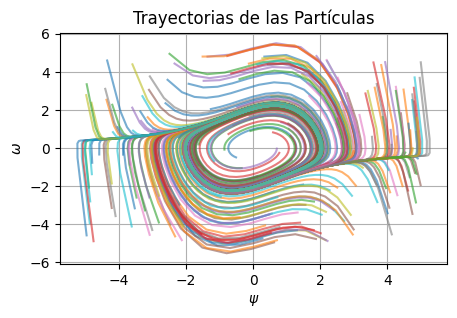

In [7]:
# Separar en train, valid, test
train_data = trayectorias[:210, :, :]
val_data = trayectorias[210:255, :, :]
test_data = trayectorias[255:, :, :]

# Imprimir las formas de los conjuntos de datos
print("Forma del conjunto de entrenamiento: ", train_data.shape)
print("Forma del conjunto de validación: ", val_data.shape)
print("Forma del conjunto de prueba: ", test_data.shape)

# Obtener tensores X_train, P_train, X_valid, P_valid
X_train = train_data[:, 0, :]
P_train = train_data[:, 1, :]
X_valid = val_data[:, 0, :]
P_valid = val_data[:, 1, :]
X_test = test_data[:, 0, :]
P_test = test_data[:, 1, :]

# Imprimir las formas de los tensores
print("Forma de X_train: ", X_train.shape)
print("Forma de P_train: ", P_train.shape)

plot_trayectoria(train_data, 210)

# El modelo

Debido a que este modelo utiliza condiciones iniciales y no las toma como input, significa que el modelo habrá de aprender estas condiciones iniciales,
por tanto solo puede aprender de una curva a la vez


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)

        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1) 
        z = self.hidden1(inputs_expanded)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [9]:
t = tf.range(300, dtype=tf.float32)

In [10]:
@tf.function
def physics_loss(y_true, y_pred, model, inputs, X_target, P_target, params):
    mu = params.get('mu', 2.0)
    position_weight = params.get('position_weight', 10)
    momentum_weight = params.get('momentum_weight', 5)
    data_weight = params.get('data_weight', 1)
    phys_weight = params.get('phys_weight', 1)

    inputs = tf.expand_dims(inputs, axis=-1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted
    
    # Physics loss
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))
    
    loss = phys_weight * tf.reduce_mean(tf.square(f))
    loss += position_weight * position_loss
    loss += momentum_weight * momentum_loss
    
    # Data loss (optional, depending on your needs)
    # data_loss = data_weight * tf.reduce_mean(tf.square(y_true - y_pred))
    # loss += data_loss
    
    return loss


In [11]:
def train(model, inputs, targets, params, optimizer, epochs=100, batch_size=32):
    # Compile the model with the partial physics loss function
    X_target = targets[0]
    P_target = targets[1]

    partial_physics_loss = functools.partial(physics_loss, model=model, 
        X_target=X_target, P_target=P_target, params=params)
    model.compile(optimizer=optimizer, loss=partial_physics_loss)

    # Train the model
    history = model.fit(inputs, X_target, epochs=epochs, batch_size=batch_size)

    return history


In [12]:
params = {'mu': 2.0, 'position_weight': 10.0, 'momentum_weight': 5.0, 'phys_weight': 1.0}
model = VanderPolModel()
inputs = t
history = train(model, inputs, [X_train[0], P_train[0]], params, optimizer=optimizers.Adam(learning_rate=0.0001))


Epoch 1/100


TypeError: in user code:

    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: Binding inputs to tf.function `physics_loss` failed due to `missing a required argument: 'inputs'`. Received args: (<tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'vander_pol_model/dense_4/Tanh:0' shape=(None, 1) dtype=float32>) and kwargs: {'model': <__main__.VanderPolModel object at 0x000001A0405BB190>, 'X_target': <tf.Tensor: shape=(300,), dtype=float32, numpy=
    array([-1.2586555 , -0.9773873 , -0.6782683 , -0.3553906 , -0.00664393,
            0.36549222,  0.75324374,  1.1373498 ,  1.4936745 ,  1.7973999 ,
            2.0295663 ,  2.1863472 ,  2.272483  ,  2.3006206 ,  2.2859707 ,
            2.2387366 ,  2.167271  ,  2.0770934 ,  1.9713508 ,  1.8520107 ,
            1.7199154 ,  1.575092  ,  1.4170353 ,  1.2447256 ,  1.0569463 ,
            0.8518112 ,  0.62698704,  0.38126644,  0.11459704, -0.17191827,
           -0.47491458, -0.7845514 , -1.0874504 , -1.3679277 , -1.6088892 ,
           -1.7987192 , -1.9327415 , -2.0122104 , -2.0441437 , -2.0371487 ,
           -1.9984493 , -1.9342282 , -1.8492283 , -1.7462472 , -1.627058  ,
           -1.4925641 , -1.342962  , -1.1778042 , -0.99575824, -0.79558676,
           -0.5762002 , -0.33665615, -0.07629424,  0.20333424,  0.49740896,
            0.7971585 ,  1.0898769 ,  1.3593528 ,  1.5905958 ,  1.7732323 ,
            1.9019978 ,  1.9794961 ,  2.0113995 ,  2.0044577 ,  1.9662825 ,
            1.9028132 ,  1.817982  ,  1.7147233 ,  1.5949996 ,  1.4598204 ,
            1.3092127 ,  1.1426951 ,  0.959351  ,  0.75782865,  0.53697985,
            0.29534695,  0.03274211, -0.24820058, -0.5420243 , -0.84037197,
           -1.129383  , -1.3926336 , -1.6169392 , -1.7926235 , -1.9145553 ,
           -1.9858902 , -2.0124388 , -2.0010734 , -1.9593887 , -1.8929933 ,
           -1.8056686 , -1.7002141 , -1.5784676 , -1.4413142 , -1.2886927 ,
           -1.1200622 , -0.93445635, -0.73048425, -0.5070537 , -0.2627063 ,
            0.00245876,  0.2854536 ,  0.5804014 ,  0.8784174 ,  1.1650149 ,
            1.4239012 ,  1.6423634 ,  1.8114529 ,  1.9268119 ,  1.9921743 ,
            2.013688  ,  1.9982886 ,  1.9533788 ,  1.8843434 ,  1.7947878 ,
            1.6873523 ,  1.563732  ,  1.4247472 ,  1.270248  ,  1.0996227 ,
            0.91188425,  0.7056716 ,  0.4797587 ,  0.2330604 , -0.03436832,
           -0.31928384, -0.6152234 , -0.9124463 , -1.1960566 , -1.4500045 ,
           -1.662778  , -1.827605  , -1.9424527 , -2.008178  , -2.0296736 ,
           -2.014606  , -1.9696945 , -1.9007022 , -1.8119097 , -1.7055625 ,
           -1.5830928 , -1.4451694 , -1.291698  , -1.1220621 , -0.93556404,
           -0.7302468 , -0.504837  , -0.25895298,  0.00689543,  0.29109764,
            0.58777386,  0.8863651 ,  1.1733361 ,  1.4325567 ,  1.6496257 ,
            1.8157358 ,  1.9280936 ,  1.9899273 ,  2.0085783 ,  1.9913628 ,
            1.9447893 ,  1.8745013 ,  1.7843345 ,  1.6764901 ,  1.5523477 ,
            1.41249   ,  1.2567581 ,  1.0849396 ,  0.8955729 ,  0.6872348 ,
            0.4590035 ,  0.21045908, -0.05825555, -0.34444508, -0.6412047 ,
           -0.93788016, -1.2201207 , -1.4718239 , -1.6796374 , -1.8359643 ,
           -1.9391321 , -1.9933659 , -2.0059357 , -1.9838023 , -1.9334381 ,
           -1.8602065 , -1.767304  , -1.6568805 , -1.5302522 , -1.3879012 ,
           -1.2299458 , -1.0555408 , -0.86336017, -0.65227515, -0.42135447,
           -0.16986564,  0.1016963 ,  0.38973185,  0.68699217,  0.98221797,
            1.2606045 ,  1.5059826 ,  1.7063354 ,  1.8547361 ,  1.9502212 ,
            1.9982226 ,  2.0052915 ,  1.9783616 ,  1.924271  ,  1.8475997 ,
            1.7514786 ,  1.6381136 ,  1.5088074 ,  1.3641372 ,  1.2036865 ,
            1.0266502 ,  0.83197963,  0.61838317,  0.38449273,  0.12982863,
           -0.14457332, -0.43435854, -0.7316778 , -1.0251873 , -1.3000691 ,
           -1.5400397 , -1.7330366 , -1.8731682 , -1.9607736 , -2.0014875 ,
           -2.0025337 , -1.9708799 , -1.9130117 , -1.8332072 , -1.7342697 ,
           -1.618164  , -1.4860163 , -1.3383948 , -1.1749444 , -0.9946523 ,
           -0.7964208 , -0.5790685 , -0.34134743, -0.0829074 ,  0.19478779,
            0.48695496,  0.7850021 ,  1.0765338 ,  1.3455259 ,  1.5771118 ,
            1.7614713 ,  1.8939945 ,  1.9749299 ,  2.0097945 ,  2.0061023 ,
            1.9706582 ,  1.9095293 ,  1.827337  ,  1.7266892 ,  1.6093156 ,
            1.4761449 ,  1.3273044 ,  1.16256   ,  0.9810318 ,  0.78108776,
            0.56158715,  0.32189557,  0.06188478, -0.21735018, -0.5106397 ,
           -0.8089767 , -1.0995669 , -1.3666179 , -1.5949711 , -1.7744004 ,
           -1.9006729 , -1.9754407 , -2.0053463 , -1.9975591 , -1.9587699 ,
           -1.8950337 , -1.8104116 , -1.7074295 , -1.5877723 , -1.4522877 ,
           -1.3011687 , -1.1341391 , -0.9498912 , -0.7472191 , -0.5251021 ,
           -0.28270563, -0.01967497,  0.2617971 ,  0.5561681 ,  0.8539261 ,
            1.1417459 ,  1.403374  ,  1.624628  ,  1.7963672 ,  1.9149516 ],
          dtype=float32)>, 'P_target': <tf.Tensor: shape=(300,), dtype=float32, numpy=
    array([ 2.0501766 ,  2.1636293 ,  2.3194766 ,  2.506884  ,  2.699991  ,
            2.854875  ,  2.911877  ,  2.8032527 ,  2.4977288 ,  2.019087  ,
            1.4556978 ,  0.89231366,  0.40174922,  0.03415053, -0.242167  ,
           -0.45099267, -0.6092495 , -0.7352977 , -0.84271663, -0.9402636 ,
           -1.0345885 , -1.1308804 , -1.233258  , -1.3449273 , -1.4675177 ,
           -1.6034914 , -1.7541031 , -1.914254  , -2.0724072 , -2.2105913 ,
           -2.3036227 , -2.31088   , -2.2021935 , -1.9674993 , -1.6215461 ,
           -1.2124321 , -0.79044074, -0.40413964, -0.08317415,  0.17941114,
            0.3910542 ,  0.56247646,  0.7056585 ,  0.8314642 ,  0.948442  ,
            1.0622175 ,  1.1760935 ,  1.2953904 ,  1.4246392 ,  1.565246  ,
            1.7154928 ,  1.8705381 ,  2.022203  ,  2.1524525 ,  2.2328072 ,
            2.232429  ,  2.1203454 ,  1.8887879 ,  1.5580308 ,  1.1665374 ,
            0.7672442 ,  0.3989153 ,  0.08184821, -0.17782448, -0.38689783,
           -0.558365  , -0.7048729 , -0.83496046, -0.9533538 , -1.067487  ,
           -1.1837264 , -1.3061281 , -1.437336  , -1.5785819 , -1.72884   ,
           -1.8838555 , -2.032899  , -2.1569219 , -2.2285564 , -2.212217  ,
           -2.081813  , -1.8404057 , -1.5068578 , -1.1148356 , -0.7179239 ,
           -0.3553144 , -0.0454797 ,  0.20719044,  0.41066805,  0.57826066,
            0.7222452 ,  0.85070133,  0.9681337 ,  1.0822514 ,  1.1990752 ,
            1.3224914 ,  1.4549583 ,  1.5975052 ,  1.7487576 ,  1.9037567 ,
            2.0507128 ,  2.169602  ,  2.2321644 ,  2.202063  ,  2.0560372 ,
            1.801445  ,  1.4595957 ,  1.064851  ,  0.67037076,  0.31385723,
            0.01176152, -0.23382604, -0.4323874 , -0.5962902 , -0.737784  ,
           -0.8649367 , -0.9819712 , -1.0960425 , -1.2133595 , -1.3377149 ,
           -1.471369  , -1.61505   , -1.7674755 , -1.9224098 , -2.0666978 ,
           -2.179812  , -2.2338433 , -2.1924756 , -2.020165  , -1.7493001 ,
           -1.4183534 , -1.0551847 , -0.67704093, -0.31733462, -0.01349415,
            0.23378427,  0.43126735,  0.59309393,  0.7321505 ,  0.85559094,
            0.97251064,  1.0890237 ,  1.2082628 ,  1.3310335 ,  1.4621011 ,
            1.6052678 ,  1.7587763 ,  1.9153317 ,  2.0621014 ,  2.1807554 ,
            2.2410522 ,  2.2082565 ,  2.0612195 ,  1.7954938 ,  1.4398427 ,
            1.0394391 ,  0.6423539 ,  0.29177344, -0.00408008, -0.24635838,
           -0.44235328, -0.60428345, -0.7420836 , -0.86683875, -0.9865075 ,
           -1.1054268 , -1.224545  , -1.3483673 , -1.4826411 , -1.6283752 ,
           -1.7822652 , -1.9366937 , -2.0797622 , -2.190032  , -2.2341654 ,
           -2.183094  , -2.014421  , -1.7308635 , -1.3673065 , -0.9678062 ,
           -0.58191025, -0.24026933,  0.04641592,  0.27850252,  0.4674892 ,
            0.6250632 ,  0.7611675 ,  0.88598365,  1.0058117 ,  1.123074  ,
            1.2411866 ,  1.3671106 ,  1.5037689 ,  1.6507821 ,  1.8044684 ,
            1.9578449 ,  2.0980544 ,  2.1989887 ,  2.2308877 ,  2.1632888 ,
            1.9749223 ,  1.6795676 ,  1.3092967 ,  0.9098517 ,  0.52940047,
            0.19440949, -0.08431634, -0.3100563 , -0.49446946, -0.6486148 ,
           -0.7840176 , -0.90807426, -1.0243514 , -1.1392856 , -1.2590661 ,
           -1.3871261 , -1.5250041 , -1.6723444 , -1.8275431 , -1.9831119 ,
           -2.1169164 , -2.204861  , -2.2221484 , -2.1432803 , -1.9428126 ,
           -1.6297337 , -1.2484423 , -0.846319  , -0.47153515, -0.14637455,
            0.12325419,  0.34203064,  0.5203419 ,  0.67030865,  0.80394495,
            0.9285283 ,  1.0466001 ,  1.1617836 ,  1.2823896 ,  1.4120127 ,
            1.5518899 ,  1.7009044 ,  1.8556032 ,  2.0078218 ,  2.137337  ,
            2.2184434 ,  2.2218056 ,  2.1141458 ,  1.8845843 ,  1.5642983 ,
            1.1889379 ,  0.795641  ,  0.4253901 ,  0.1060877 , -0.15662618,
           -0.3672284 , -0.54005224, -0.6866818 , -0.81552666, -0.9360519 ,
           -1.0542892 , -1.1728369 , -1.2934633 , -1.4227512 , -1.5636325 ,
           -1.7146794 , -1.8701369 , -2.0199225 , -2.1484303 , -2.2255285 ,
           -2.2193034 , -2.1042056 , -1.8675387 , -1.5338466 , -1.1439775 ,
           -0.7462919 , -0.38329196, -0.0719097 ,  0.18327911,  0.38901713,
            0.5595767 ,  0.7035997 ,  0.8323693 ,  0.953842  ,  1.072088  ,
            1.188753  ,  1.3107157 ,  1.4425409 ,  1.5852646 ,  1.7366598 ,
            1.8912355 ,  2.0397334 ,  2.1614695 ,  2.227363  ,  2.2072153 ,
            2.0720668 ,  1.8205752 ,  1.4783727 ,  1.0851953 ,  0.69141203],
          dtype=float32)>, 'params': {'mu': 2.0, 'position_weight': 10.0, 'momentum_weight': 5.0, 'phys_weight': 1.0}} for signature: (y_true, y_pred, model, inputs, X_target, P_target, params).


In [ ]:
# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer, loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)

In [ ]:
physics_loss_metric = metrics.Mean('physics_loss', dtype=tf.float32)
position_loss_metric = metrics.Mean('position_loss', dtype=tf.float32)
momentum_loss_metric = metrics.Mean('momentum_loss', dtype=tf.float32)


def physics_loss(X_target, P_target, X_predicted, dx_dt, mu=2.0, position_weight=10, momentum_weight=5):
    # Calcular las pérdidas individuales
    physics_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))

    physics_loss_metric.update_state(physics_loss)
    position_loss_metric.update_state(position_loss)
    momentum_loss_metric.update_state(momentum_loss)

    # Devuelve la suma ponderada de las pérdidas
    return physics_loss + position_weight * position_loss + momentum_weight * momentum_loss

# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer.adam(), loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)


AttributeError: 'Adam' object has no attribute 'adam'

In [ ]:
# Compilar el modelo con múltiples funciones de pérdida
model = VanderPolModel()
inputs = t


# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=partial_physics_loss, 
    metrics=[physics_loss_metric, position_loss_metric,momentum_loss_metric])


# Entrenar el modelo con tus datos (asegúrate de tener X_train y P_train preparados)
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)



Epoch 1/100


TypeError: in user code:

    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\yapur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: Binding inputs to tf.function `physics_loss` failed due to `missing a required argument: 'X_target'`. Received args: (<tf.Tensor: shape=(210, 300), dtype=float32, numpy=
    array([[-1.2586555 , -0.9773873 , -0.6782683 , ...,  1.624628  ,
             1.7963672 ,  1.9149516 ],
           [ 3.0631616 ,  2.835756  ,  2.653766  , ...,  1.1529621 ,
             0.97086245,  0.7706821 ],
           [-2.8087697 , -3.1943452 , -3.3633764 , ..., -1.7944589 ,
            -1.9141258 , -1.9831786 ],
           ...,
           [ 3.5439615 ,  3.5740445 ,  3.543467  , ...,  1.8288594 ,
             1.934425  ,  1.9906261 ],
           [-2.0805404 , -2.5445867 , -2.8317099 , ..., -2.0043504 ,
            -2.0047765 , -1.972536  ],
           [-4.1763625 , -4.0812025 , -4.002547  , ..., -0.383946  ,
            -0.6812851 , -0.97683114]], dtype=float32)>, <tf.Tensor: shape=(210, 300), dtype=float32, numpy=
    array([[ 2.0501766 ,  2.1636293 ,  2.3194766 , ...,  1.4783727 ,
             1.0851953 ,  0.69141203],
           [-1.9707173 , -1.4881412 , -1.2625027 , ..., -1.2967448 ,
            -1.4271919 , -1.5677058 ],
           [-3.9048054 , -1.9550904 , -0.68802756, ..., -1.0937202 ,
            -0.69908524, -0.34127188],
           ...,
           [ 0.59257734, -0.06002376, -0.3583117 , ...,  0.9862698 ,
             0.5960323 ,  0.2528388 ],
           [-4.1204796 , -2.796322  , -1.5371017 , ..., -0.13980325,
             0.12843281,  0.3455809 ],
           [ 0.83724624,  0.6257505 ,  0.56327164, ..., -2.1990297 ,
            -2.2323518 , -2.167037  ]], dtype=float32)>, <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'vander_pol_model_3/dense_34/Tanh:0' shape=(None, 1) dtype=float32>) and kwargs: {} for signature: (y_true, y_pred, model, inputs, X_target, P_target, params).


In [ ]:
print(history.history.keys())

NameError: name 'history' is not defined

In [ ]:
import pandas as pd

pd.DataFrame(history.history)

NameError: name 'history' is not defined

# Modelo Multi Curva
El desarrollo original, pero el problema de 1 input lo hace inviable

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        z = self.hidden1(inputs)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [ ]:
# La entrada es fija
t = tf.range(300, dtype=tf.float32)
# Copiar el tensor horizontalmente
t_matrix = tf.tile(tf.expand_dims(t, axis=0), [300, 1])

# Ver la forma del tensor resultante
print(t_matrix)

tf.Tensor(
[[  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 ...
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]
 [  0.   1.   2. ... 297. 298. 299.]], shape=(300, 300), dtype=float32)


$$
\frac{d^2 x}{dt^2} - \mu(1-x^2) \frac{dx}{dt} +x = 0
$$

In [ ]:
def physics_loss(model, inputs, X_target, P_target, mu=2.0, position_weight=10, momentum_weight=5):
    inputs= tf.expand_dims(inputs, axis=-1)  # Expandir dimensiones

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted

    # Calcular la pérdida
    loss = tf.reduce_mean(tf.square(f))
    loss += position_weight*tf.reduce_mean(tf.square(X_target[:,0] - X_predicted[:,0]))
    loss += momentum_weight*tf.reduce_mean(tf.square(P_target[:,0] - dx_dt[:,0]))

    return loss


model = VanderPolModel()
inputs = t_matrix[:210]
loss = physics_loss(model, inputs, X_train, P_test)

print("Perdida Escalar:", loss)

Perdida Escalar: tf.Tensor(133.56409, shape=(), dtype=float32)


In [ ]:
# Definir el modelo y el optimizador
model = VanderPolModel()
optimizer = optimizers.Adam(learning_rate=0.001)

# Número de épocas y tamaño del lote
epochs = 100
batch_size = 32

# Bucle de entrenamiento
for epoch in range(epochs):
    # Mezclar y dividir los datos en lotes
    indices = tf.range(210)  # Asegúrate de tener el rango correcto
    tf.random.shuffle(indices)
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        inputs_batch = tf.gather(inputs, batch_indices)
        X_train_batch = tf.gather(X_train, batch_indices)
        P_train_batch = tf.gather(P_train, batch_indices)

        # Calcular la pérdida y los gradientes
        with tf.GradientTape() as tape:
            loss = physics_loss(model, inputs_batch, X_train_batch, P_train_batch)
        gradients = tape.gradient(loss, model.trainable_variables)

        # Aplicar los gradientes usando el optimizador
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Imprimir la pérdida al final de cada época
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.numpy()}")

# Verificar la pérdida final
final_loss = physics_loss(model, inputs, X_train, P_train)
print("Pérdida final:", final_loss.numpy())


Época 10/100, Pérdida: 118.50160217285156
Época 20/100, Pérdida: 118.66093444824219
Época 30/100, Pérdida: 118.66259002685547
Época 40/100, Pérdida: 118.66130828857422
Época 50/100, Pérdida: 118.66072082519531
Época 60/100, Pérdida: 118.66050720214844
Época 70/100, Pérdida: 118.66045379638672
Época 80/100, Pérdida: 118.66051483154297
Época 90/100, Pérdida: 118.6606216430664


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.tanh, input_shape=(1,)),  # Input layer (time)
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1) # output position
])

def initial_value_loss(y_true, y_pred):
    # Condición de borde
    return tf.square(y_true[0] - y_pred[0])

def point_loss(y_true, y_pred):
    # Loss function for every point
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer='adam', loss=[initial_value_loss, point_loss])

In [ ]:
x_pred = next(iter(train_data.take(1)))[0,:]
v_pred = next(iter(train_data.take(1)))[1,:]

In [ ]:
x_pred.shape

TensorShape([300])

In [ ]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100)

# un optimizador

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner

# Supongamos que tus datos están en el tensor 'trayectorias'
trayectorias

# Separa tus datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(trayectorias, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

def build_model(hp):
    # aqui va la construccion del modelo
    model = tf.keras.models.Sequential()
    
    # Añade tus capas aquí. Por ejemplo:
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # una sola salida para predecir la posición

    # Ajusta los hiperparámetros del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss=tf.keras.losses.MeanSquaredError(),  # usa MSE para la regresión
                metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='mse',  # minimiza el error cuadrático medio
    max_trials=5,
    executions_per_trial=3)

tuner.search(train_data, epochs=60, validation_data=val_data)

# Obtén los hiperparámetros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"La tasa de aprendizaje óptima para el optimizador es {best_hps.get('learning_rate')}.")
print(f"El beta_1 óptimo para el optimizador es {best_hps.get('beta_1')}.")
print(f"El beta_2 óptimo para el optimizador es {best_hps.get('beta_2')}.")


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([232,  59,   6, 185, 173,  30,  22, 256,  56, 186, 108, 126, 230,
       193, 129, 282,  82,  84,  66, 288, 163, 154,  19, 124,  79, 114,
       118,  72,  15,  10, 194, 101,  68, 224,  37,  16, 179, 147, 274,
        67, 228,  69,  31, 183, 265, 225, 140,  18, 181,  96, 132, 262,
        86, 248, 245, 116, 146, 292, 197, 206,  55, 172, 184, 167, 139,
       253,  38, 125, 195, 283, 137, 112, 168, 117, 277, 271, 155, 176,
       178,   2, 115, 143, 177, 120, 210, 260, 127,  74,  29,  83, 269,
       107, 223, 158, 280, 246, 222,  65, 198,  85, 213, 159,  12,  35,
        28, 142, 284, 254, 170,  51,  95, 208, 247,  41,  89, 244, 136,
        26, 293, 141, 200,   0, 268, 272, 100, 259, 255, 171,  98,  36,
        61, 150, 236, 202, 242,  11, 296, 267,  27, 219,   4, 122,  32,
       204, 162, 209, 285, 138,  62, 135, 128, 290,   8,  70, 264,  64,
        44, 279, 156,  40, 123, 275, 216, 153,  23, 261, 110,  81, 207,
       212,  39, 240, 291, 258, 199,  14,  47,  94, 263, 227, 273, 201,
       161,  43, 217, 145, 190, 220, 251,   3, 105,  53, 133,   1, 131,
       103,  49,  80, 205,  34,  91,  52, 241,  13,  88, 166, 294, 134,
       287, 243,  54,  50, 174, 189, 298, 187, 169,  58,  48, 235, 252,
        21, 160, 276, 191, 257, 149, 130, 151,  99,  87, 214, 121, 299,
        20, 188,  71, 106, 270, 102])

## Alternativa

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Paso 1: Implementar el modelo
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),  # 1 neurona de entrada
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(1)  # 1 neurona de salida
    ])
    return model

# Función de Van der Pol unidimensional
def van_der_pol(x, mu):
    dxdt = mu * (1 - x**2) * x
    return dxdt

In [43]:
# Parámetros
mu = 2.0
h = 0.01  # Tamaño del paso
num_samples = 1000

# Función de pérdida personalizada
def custom_loss(y_true, y_pred):
    # Pérdida de la ecuación de Van der Pol
    t_values = tf.range(0, tf.shape(y_true)[0])  # Secuencia de tiempo
    loss_van_der_pol = tf.reduce_mean(tf.square(y_true - y_pred - h * van_der_pol(y_pred, mu)))
    
    # Pérdida de la condición inicial
    loss_initial_condition = tf.reduce_sum(tf.square(y_true[0, 0] - y_pred[0, 0]))
    
    # Peso para equilibrar ambas pérdidas
    alpha = 0.1
    
    # Pérdida total
    loss = loss_van_der_pol + alpha * loss_initial_condition
    
    return loss

In [44]:
# Generar datos de entrenamiento
initial_condition = np.array([[1.0]])
initial_condition = np.expand_dims(initial_condition, axis=-1)

y_train_input = np.zeros((num_samples, 1, 1))  # Entrada
y_train_output = np.concatenate([initial_condition, np.zeros((num_samples - 1, 1, 1))], axis=0)  # Salida


In [45]:
# Crear y entrenar el modelo
model = create_model()
model.compile(optimizer='adam', loss=custom_loss)
model.fit(y_train_input, y_train_output, epochs=1000, verbose=0)

32/32 [==============================] - 0s 1ms/step


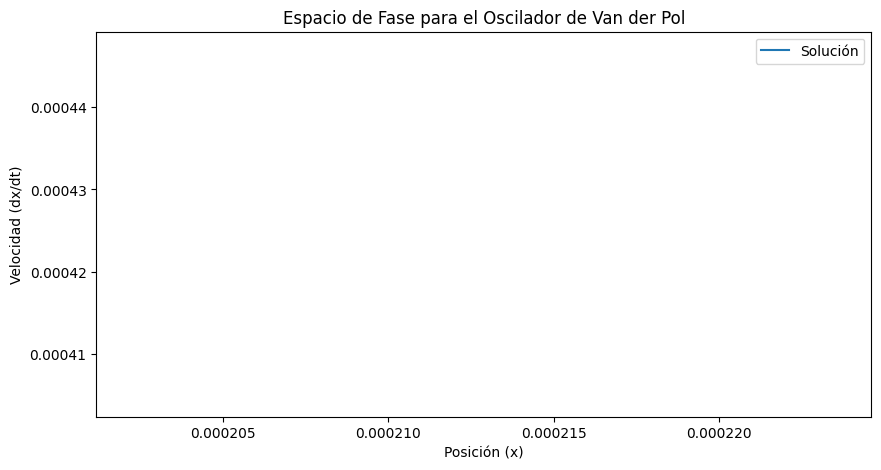

In [46]:
# Resolver la ecuación diferencial usando el modelo entrenado
solution = model.predict(y_train_input)

# Visualizar la solución en el espacio de fase
plt.figure(figsize=(10, 5))
plt.plot(solution[:, 0], van_der_pol(solution[:, 0], mu), label='Solución')
plt.title('Espacio de Fase para el Oscilador de Van der Pol')
plt.xlabel('Posición (x)')
plt.ylabel('Velocidad (dx/dt)')
plt.legend()
plt.show()